In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os
import pylab
import timeit
import sklearn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2
%matplotlib inline

In [118]:
# Format to remove scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Reading data

In [3]:
#apc_1023
start = timeit.default_timer()
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1203.h5')
data1 = store['APCdata']
stop = timeit.default_timer()
print 'apc_1203:', stop - start #apc_1203: 63.1637678053

#apc_1206
start = timeit.default_timer()
store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1206.h5')
data2 = store['APCdata']
stop = timeit.default_timer()
print 'apc_1206:', stop - start #apc_1206: 72.5603196086

#apc_1209
#start = timeit.default_timer()
#store = pd.HDFStore(r'R:\Angela\fast_trips\apc_1209.h5')
#data3 = store['APCdata']
#stop = timeit.default_timer()
#print 'apc_1209:', stop - start #apc_1209: 99.1659132181

print 'finish reading data'

apc_1203: 26.2538616247
apc_1206: 26.9321673726
finish reading data


In [4]:
def data_need(data):
    data = data[['on', 'off', 'vehno', 'route', 'stop_name', 'stop_sequence', 'mo', 'yr', 'arr_hour', 'arr_min', 'arr_sec', 'dep_hr', 'dep_min', 'dep_sec']]
    return data
data1 = data_need(data1)
data2 = data_need(data2)
#data3 = data_need(data3)

combined_data = pd.concat([data1,data2])
#in this case, we applied data1 and data2
#if you decided to go with the whole dataset
#combined_data = pd.read_csv(r'R:\Angela\fast_trips\apc_1203_1206_1209.csv')

#Prepare bus info

In [5]:
vehicles = pd.read_csv(r'R:\Angela\fast_trips\Vehicles.csv')
fleet = pd.read_csv(r'R:\Angela\fast_trips\Copy of Fleet.csv')
vehicles.Artic = vehicles.Length.map({60 : 1, 40 : 0, 30 : 0})
vehicles.Floor = vehicles['Low Floor'].map({'Y': 1, 'N' : 0})
vehicles.loc[:,'Artic'] = pd.Series(vehicles.Artic, index=vehicles.index)
vehicles.loc[:,'Floor'] = pd.Series(vehicles.Floor, index=vehicles.index)
df_artic = vehicles.set_index('Equip_Type').to_dict()['Artic']
df_floor = vehicles.set_index('Equip_Type').to_dict()['Floor']
df_doors = vehicles.set_index('Equip_Type').to_dict()['Doors']
fleet['Doors'] = fleet['Equip_Type'].map(df_doors)
fleet['Artic'] = fleet['Equip_Type'].map(df_artic)
fleet['Floor'] = fleet['Equip_Type'].map(df_floor)
df_vehnum_doors = fleet.set_index('VehNum').to_dict()['Doors']
df_vehnum_artic = fleet.set_index('VehNum').to_dict()['Artic']
df_vehnum_floor = fleet.set_index('VehNum').to_dict()['Floor']

# Prepare route type

In [6]:
route_type = pd.read_csv(r'R:\Angela\fast_trips\MuniRouteTypes.csv')
route_type = route_type.dropna()
dict_route_type = {}
dict_route_type = route_type.set_index('APC Route ID')['Type'].to_dict()

# Variables

In [7]:
def get_x_y(data):
    start = timeit.default_timer()
    #Get rid of rows where certain fields has null/nan values
    data = data.dropna(subset = ['on', 'off', 'vehno'])
    #input bus type info into raw data
    #COMPUTE EOL = RINDEX(ANAME,' - EOL') 
    data['EOL']= data.apply(lambda x: '- EOL' in x['stop_name'], axis=1).map({False: 1, True: 0})
    #remove the last stop
    data = data.loc[data['EOL'] == 1]
    #remove the first stop
    data = data.loc[data['stop_sequence'] != 1]
    stop = timeit.default_timer()
    print 'clean data:', stop - start

    #COMPUTE TIMESTOP=((HR * 3600) + (MIN * 60) + SEC)
    start = timeit.default_timer()
    data['COMPUTE_TIMESTOP'] = data['arr_hour']*3600 + data['arr_min']*60 + data['arr_sec']
    #COMPUTE DOORCLOSE=(( DHR * 3600) + (DMIN * 60) + DSEC)
    data['COMPUTE_DOORCOLSE'] = data['dep_hr']*3600 + data['dep_min']*60 + data['dep_sec']
    #COMPUTE DOORDWELL=DOORCLOSE-TIMESTOP
    data['COMPUTE_DOORDWELL'] = data['COMPUTE_DOORCOLSE'] - data['COMPUTE_TIMESTOP']
    #appling door dwell time less than 120 secs
    data = data.loc[data['COMPUTE_DOORDWELL'] <= 90]
    stop = timeit.default_timer()
    print 'compute dwell time:', stop - start

    #Keep rows that satisfy a query:
    start = timeit.default_timer()
    data['Doors'] = data['vehno'].map(df_vehnum_doors) 
    data['Artic'] = data['vehno'].map(df_vehnum_artic)
    data['Floor'] = data['vehno'].map(df_vehnum_floor)
    data['two_doors'] = data['Doors'].map({2: 1, 3: 0})
    data['three_doors'] = data['Doors'].map({2: 0, 3: 1})
    data['all_door_boarding']= data.apply(lambda x: x['mo'] > 6, axis=1).map({False: 0, True: 1})
    #make dummie variables for route id
    data['Route Type'] = data['route'].map(dict_route_type)
    just_dummies_route = pd.get_dummies(data['Route Type'])
    step_1 = pd.concat([data, just_dummies_route], axis=1)
    step_1.drop(['Local'], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add veh&route info:', stop - start

    #Create dummie variables for bus id 
    start = timeit.default_timer()
    just_dummies_veh = pd.get_dummies(data['vehno'])
    step_1 = pd.concat([data, just_dummies_veh], axis=1)
    #get rid of one dummy variable to avoid the dummy variable trap
    step_1.drop([8515], inplace=True, axis=1)
    data = step_1
    stop = timeit.default_timer()
    print 'add bus id variables:', stop - start

    #Create interaction variables
    start = timeit.default_timer()
    data['on_threedoors'] = data['on']*data['three_doors']
    data['off_threedoors'] = data['off']*data['three_doors']
    data['on_floor'] = data['on']*data['Floor']
    data['off_floor'] = data['off']*data['Floor']
    data['floor_threedoors'] = data['Floor']*data['three_doors']
    data['floor_twodoors'] = data['Floor']*data['two_doors']
    data['on_all_door_boarding'] = data['on']*data['all_door_boarding']
    data['off_all_door_boarding'] = data['off']*data['all_door_boarding']
    data['on_express'] = data['on']*data['Express']
    data['off_express'] = data['off']*data['Express']
    data['on_rapid'] = data['on']*data['Rapid']
    data['off_rapid'] = data['off']*data['Rapid']
    data['on_owl'] = data['on']*data['OWL']
    data['off_owl'] = data['off']*data['OWL']
    stop = timeit.default_timer()
    print 'add interaction variables:', stop - start

    return data

# Data to apply

In [143]:
#for now, the datasets applied are apc_1203 data and apc_1206 data
#test 1% of the combined_data
test_percent = 0.01
test_percent_title = str(test_percent)
msk = np.random.rand(len(combined_data)) < (1-test_percent)
test = combined_data[~msk]
print len(test)

data = get_x_y(test)
print 'finished data preparation'

198896
clean data: 2.53456785391
compute dwell time: 0.107190365958
add veh&route info: 2.6020901809
add bus id variables: 1.67361351123
add interaction variables: 0.0258536354195
finished data preparation


In [144]:
#to check whether vehcle:8515 is in the sample, if it is not, we should pick up another veh id to delete
np.unique(test['vehno'])

array([2801, 2802, 2804, 2806, 5446, 5447, 5448, 5449, 5450, 5451, 5452,
       5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463,
       5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474,
       5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485,
       5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496,
       5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507,
       5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518,
       5519, 5520, 5521, 5522, 5523, 5524, 5525, 6200, 6201, 6202, 6203,
       6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214,
       6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225,
       6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6401, 6402, 6403,
       7105, 7106, 7107, 7108, 7110, 7111, 7112, 7113, 7114, 7115, 7116,
       7117, 7118, 7119, 7120, 7121, 7122, 7123, 8001, 8002, 8003, 8004,
       8005, 8006, 8007, 8008, 8010, 8011, 8013, 80

# Build multi-linear regression model

# Model - with vehicle ids

In [145]:
#Run Linear Regression In Python SciKit-Learn
start = timeit.default_timer()
X = data.drop(['COMPUTE_DOORDWELL','vehno','stop_name', 'stop_sequence', 'arr_hour','arr_min','arr_sec','route','mo','yr', 'dep_hr','dep_min','dep_sec', 'EOL','COMPUTE_TIMESTOP','COMPUTE_DOORCOLSE','COMPUTE_DOORDWELL','Doors','two_doors', 'Artic', 'Route Type', 'floor_threedoors', 'floor_twodoors'], axis=1)
# impute missing values
X[np.isnan(X)] = np.median(X[~np.isnan(X)])
y = data.COMPUTE_DOORDWELL
print 'done'

done


In [146]:
#train 98% data
#validate 2% data
length = len(X) * 0.02
length_index = (-1) * int(length)
X_train = X[:length_index]
X_test = X[length_index:]
y_train = y[:length_index]
y_test = y[length_index:]
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(184169, 257)
(3758, 257)
(184169L,)
(3758L,)


In [147]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
pred_train = lm1.predict(X_train)
pred_test = lm1.predict(X_test)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results = pd.DataFrame(zip(X_train.columns, lm1.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X_train, y_train)
sklearn_results['pvalues'] = pd.DataFrame(pvalues)
sklearn_results['scores'] = pd.DataFrame(scores)
#sklearn_results.to_csv('R:/Angela/fast_trips/muni_apc_2012/1%_del_8515_of_1203_1206_datasets_datasets_withVeh15.csv')
stop = timeit.default_timer()
print 'build model with veh ids:', stop - start

build model with veh ids: 10.4167276652


In [148]:
print sklearn_results

                  features  estimatedCoefficients  pvalues     scores
0                       on                  2.647    0.000 361964.759
1                      off                  1.687    0.000 235096.079
2                    Floor       102007984527.040    0.000   3175.289
3              three_doors      1356894740074.625    0.000   2904.979
4        all_door_boarding                 -0.002    0.306     96.281
5                  Express                  1.216    0.000   1286.692
6                      OWL                 -0.882    0.001    139.417
7                    Rapid                  3.821    0.000   3414.421
8                     2801       102007984526.624    0.429     91.737
9                     2802       102007984526.552    1.000     45.214
10                    2804       102007984527.601    0.000    239.881
11                    2806       102007984526.044    0.339     95.008
12                    5446       102007984531.265    0.158    103.421
13                  

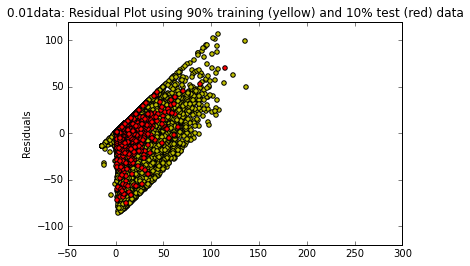

In [149]:
plt.scatter(lm1.predict(X_train), lm1.predict(X_train) - y_train, c='y', s=20)
plt.scatter(lm1.predict(X_test), lm1.predict(X_test) - y_test, c='r', s=20)
#plt.hlines(y=0, xmin=0, xmax=50)
plt.axis([-50, 300, -120, 120])
plt.title(test_percent_title + 'data: Residual Plot using 90% training (yellow) and 10% test (red) data')
plt.ylabel('Residuals')
plt.show()
#pylab.savefig(r'R:\Angela\fast_trips\muni_apc_2012\1%_del_8515_of_1203_1206_datasets_withVeh15.png')

# Model - without vehicle IDs

In [150]:
start = timeit.default_timer()
X2 = data[['on','off','Floor','three_doors','all_door_boarding','Express','OWL','Rapid','on_threedoors','off_threedoors','on_floor','off_floor','on_all_door_boarding','off_all_door_boarding','on_express','off_express','on_rapid','off_rapid','on_owl','off_owl']]
X2[np.isnan(X2)] = np.median(X2[~np.isnan(X2)])
y2 = data.COMPUTE_DOORDWELL
print 'done'

done


C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [151]:
X2_train = X2[:length_index]
X2_test = X2[length_index:]
y2_train = y2[:length_index]
y2_test = y2[length_index:]
print X2_train.shape
print X2_test.shape
print y2_train.shape
print y2_test.shape

(184169, 20)
(3758, 20)
(184169L,)
(3758L,)


In [152]:
lm2 = LinearRegression()
lm2.fit(X2_train, y2_train)
LinearRegression(copy_X=True, fit_intercept=True,normalize=False)

#construct a data frame that contains features and estimated coefficients
sklearn_results = pd.DataFrame(zip(X2_train.columns, lm2.coef_), columns = ['features', 'estimatedCoefficients'])
#p-values
scores, pvalues = chi2(X2_train, y2_train)
sklearn_results['pvalues'] = pd.DataFrame(pvalues)
sklearn_results['scores'] = pd.DataFrame(scores)
#sklearn_results.to_csv('R:/Angela/fast_trips/muni_apc_2012/1%_del_8515_of_1203_1206_datasets_datasets_withoutVeh15.csv')
stop = timeit.default_timer()
print 'build model without veh ids:', stop - start

build model without veh ids: 4.82051326942


In [153]:
print sklearn_results

                 features  estimatedCoefficients  pvalues     scores
0                      on                  2.631    0.000 361964.759
1                     off                  1.677    0.000 235096.079
2                   Floor                 -2.185    0.000   3175.289
3             three_doors                  1.396    0.000   2904.979
4       all_door_boarding                  0.048    0.306     96.281
5                 Express                  0.593    0.000   1286.692
6                     OWL                 -1.210    0.001    139.417
7                   Rapid                  3.380    0.000   3414.421
8           on_threedoors                 -0.111    0.000 145084.313
9          off_threedoors                 -0.314    0.000  90209.880
10               on_floor                  0.558    0.000  18411.534
11              off_floor                  0.772    0.000  16535.555
12   on_all_door_boarding                 -0.191    0.000 147610.467
13  off_all_door_boarding         

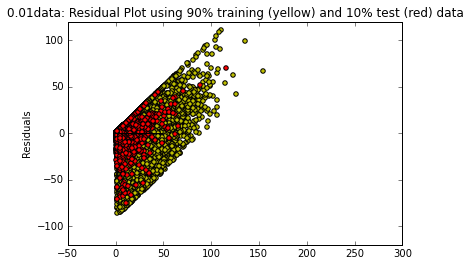

In [154]:
plt.scatter(lm2.predict(X2_train), lm2.predict(X2_train) - y2_train, c='y', s=20)
plt.scatter(lm2.predict(X2_test), lm2.predict(X2_test) - y2_test, c='r', s=20)
plt.hlines(y=0, xmin=0, xmax=50)
plt.axis([-50, 300, -120, 120])
plt.title(test_percent_title + 'data: Residual Plot using 90% training (yellow) and 10% test (red) data')
plt.ylabel('Residuals')
plt.show()
#pylab.savefig(r'R:\Angela\fast_trips\muni_apc_2012\1%_del_8515_of_1203_1206_datasets_datasets_withoutVeh15.png')

In [155]:
print 'end'

end
